In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Membaca data dari CSV
df = pd.read_csv("/content/drive/MyDrive/Kuliah/PKK/Projek/data_building_wonomerto.csv")
locations = df[['lat', 'lon']].values

In [ ]:
print(locations)

[[ -7.07104452 109.78460294]
 [ -7.07024754 109.78433634]
 [ -7.07134368 109.78335614]
 ...
 [ -7.0640809  109.79348313]
 [ -7.06410752 109.7937987 ]
 [ -7.06213642 109.79385472]]


Menetapkan seed untuk generator bilangan acak agar hasil eksperimen selalu sama tiap dijalankan.

In [ ]:
random.seed(0)

Fungsi objektif: total jarak ke semua rumah dengan menhitung jarak euclid longitude dan latitude

In [ ]:
def objective_function(position):
    total_distance = 0
    for loc in locations:
        distance = ((position[0] - loc[0])**2 + (position[1] - loc[1])**2) ** 0.5
        total_distance += distance
    return total_distance

Kelas partikel sebagai representasi individu dan fungsi-fungsinya. Mewakili satu kandidat solusi dan menyimpan posisi, kecepatan, dan solusi terbaik pribadi

In [ ]:
class Particle:
    def __init__(self, lat_range, lon_range):
        self.position = [random.uniform(*lat_range), random.uniform(*lon_range)]
        self.velocity = [random.uniform(-0.001, 0.001), random.uniform(-0.001, 0.001)]
        self.best_position = list(self.position)
        self.best_value = objective_function(self.position)

    #Fungsi untuk menghitung kecepatan baru berdasarkan parameter yang ada
    def update_velocity(self, global_best, c1, c2, w):
        for i in range(2):
            r1 = random.random()
            r2 = random.random()
            cognitive = c1 * r1 * (self.best_position[i] - self.position[i])
            social = c2 * r2 * (global_best[i] - self.position[i])
            self.velocity[i] = w * self.velocity[i] + cognitive + social

    #Fungsi untuk menghasilakn posisi baru
    def update_position(self, lat_range, lon_range):
        for i in range(2):
            self.position[i] += self.velocity[i]
        # Batas wilayah
        self.position[0] = min(max(self.position[0], lat_range[0]), lat_range[1])
        self.position[1] = min(max(self.position[1], lon_range[0]), lon_range[1])

        # Update posisi terbaik pribadi
        current_value = objective_function(self.position)
        if current_value < self.best_value:
            self.best_value = current_value
            self.best_position = list(self.position)

Fungsi PSO

Parameter yang digunakan sebagai input
- num_particles: jumlah partikel dalam swarm.
- max_iter: jumlah iterasi.
- c1 : bobot kognitif.
- c2: bobot sosial.
- w: koefisien inersia.

In [ ]:
def pso(num_particles=30, max_iter=40, c1=2.05, c2=2.05, w=0.729):

    #Batas minimum dan maksimum ruang pencarian
    lat_range = (df['lat'].min(), df['lat'].max())
    lon_range = (df['lon'].min(), df['lon'].max())

    #Inisialisasi seluruh partikel
    swarm = [Particle(lat_range, lon_range) for _ in range(num_particles)]

    #Menentukan posisi dan nilai terbaik global awal
    global_best = min(swarm, key=lambda p: p.best_value).best_position
    global_best_value = objective_function(global_best)

    #Melakukan perulangan untuk mengupdate seluruh partikel dan menyimpan hasil terbaik global
    for iteration in range(max_iter):
        for particle in swarm:
            particle.update_velocity(global_best, c1, c2, w)
            particle.update_position(lat_range, lon_range)

        for particle in swarm:
            if objective_function(particle.best_position) < global_best_value:
                global_best = list(particle.best_position)
                global_best_value = objective_function(global_best)

        print(f"Iterasi {iteration+1}: Lokasi terbaik = {global_best}, Jarak total = {global_best_value}")

    return global_best, global_best_value

Menjelaankan PSO

In [ ]:
best_location, best_value = pso()
print(f"\nLokasi ideal sekolah: Latitude = {best_location[0]}, Longitude = {best_location[1]}, Jarak total = {best_value}")

Iterasi 1: Lokasi terbaik = [-7.0690266422445305, 109.790185828055], Jarak total = 5.358677077890489
Iterasi 2: Lokasi terbaik = [-7.0690266422445305, 109.790185828055], Jarak total = 5.358677077890489
Iterasi 3: Lokasi terbaik = [-7.06982858912609, 109.79031864597081], Jarak total = 5.337904699713765
Iterasi 4: Lokasi terbaik = [-7.069859610103373, 109.79065609929516], Jarak total = 5.326014474796128
Iterasi 5: Lokasi terbaik = [-7.069859610103373, 109.79065609929516], Jarak total = 5.326014474796128
Iterasi 6: Lokasi terbaik = [-7.069634667031869, 109.79066799782612], Jarak total = 5.318829447630449
Iterasi 7: Lokasi terbaik = [-7.069634667031869, 109.79066799782612], Jarak total = 5.318829447630449
Iterasi 8: Lokasi terbaik = [-7.069501543765872, 109.79085061206423], Jarak total = 5.316906716746129
Iterasi 9: Lokasi terbaik = [-7.069501543765872, 109.79085061206423], Jarak total = 5.316906716746129
Iterasi 10: Lokasi terbaik = [-7.069501543765872, 109.79085061206423], Jarak total = 

Visualisasi hasil

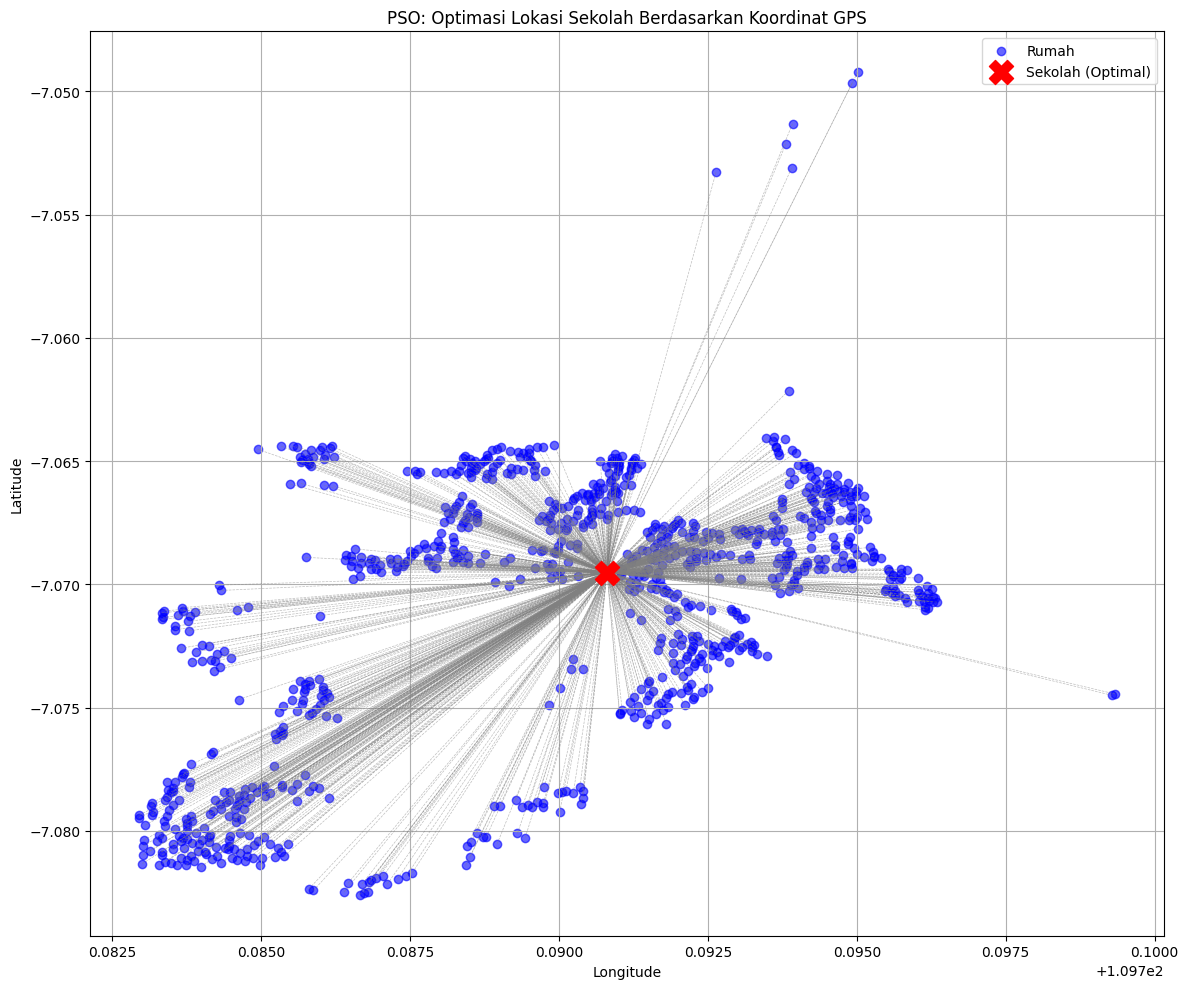

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter([lon for _, lon in locations], [lat for lat, _ in locations],
            c='blue', label='Rumah', alpha=0.6)

for lat, lon in locations:
    plt.plot([lon, best_location[1]], [lat, best_location[0]],
             c='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.scatter(best_location[1], best_location[0],
            c='red', marker='X', s=300, label='Sekolah (Optimal)', zorder=5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("PSO: Optimasi Lokasi Sekolah Berdasarkan Koordinat GPS")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()